In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --upgrade httpx
!pip install --upgrade langsmith openai
!pip uninstall httpx langsmith openai -y
!pip install httpx langsmith openai
!pip show httpx
!pip install googletrans==4.0.2
!pip install torch torchvision pandas numpy scikit-learn tqdm langdetect pyspellchecker torchmetrics umap-learn hdbscan
!pip install nest-asyncio

import httpx
print(httpx.__version__)

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.retrieval import RetrievalPrecision, RetrievalRecall, RetrievalMRR, RetrievalNormalizedDCG
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchmetrics
import umap
import hdbscan
import asyncio
from langdetect import detect
from googletrans import Translator
from spellchecker import SpellChecker
import nest_asyncio
import re
from datetime import datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 8.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.4/567.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 77.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: openai
    Found existing installation: openai 1.57.4
    Uninstalling openai-1.57.4:
      Successfully uninstalled openai-1.57.4
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.2.3
    Uninstalling langsmith-0.2.3:
      Successfully uninstalled langsmith-0.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.12 requires async-timeout<5.0.0,>=4.0.0; python_version < "3.11", but you have async-timeout 5.0.1 which is incompatible.
langchain 0.3.12 requires langsmith<0.3,>=0.1.17, but you have langsmith 0.3.14 which is incompatible.
langchain-core 0.

In [3]:
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}, Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch version: 2.5.1+cu121
CUDA version: 12.1
Number of GPUs: 1
Current GPU: 0, Name: Tesla T4


In [4]:
dataset_path = "/kaggle/input/movielens-10m-dataset"
if not os.path.exists(dataset_path):
    !wget -nc http://files.grouplens.org/datasets/movielens/ml-10m.zip -P /kaggle/working/
    !unzip -n /kaggle/working/ml-10m.zip -d /kaggle/working/
    dataset_path = "/kaggle/working/ml-10M100K"

--2025-03-14 23:30:40--  http://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: ‘/kaggle/working/ml-10m.zip’

ml-10m.zip          100%[===================>]  62.53M  71.4MB/s    in 0.9s    

2025-03-14 23:30:41 (71.4 MB/s) - ‘/kaggle/working/ml-10m.zip’ saved [65566137/65566137]

Archive:  /kaggle/working/ml-10m.zip
   creating: /kaggle/working/ml-10M100K/
  inflating: /kaggle/working/ml-10M100K/allbut.pl  
  inflating: /kaggle/working/ml-10M100K/movies.dat  
  inflating: /kaggle/working/ml-10M100K/ratings.dat  
  inflating: /kaggle/working/ml-10M100K/README.html  
  inflating: /kaggle/working/ml-10M100K/split_ratings.sh  
  inflating: /kaggle/working/ml-10M100K/tags.dat  


In [5]:
ratings = pd.read_csv(f"{dataset_path}/ratings.dat", sep="::", engine="python",
                      names=["userId", "movieId", "rating", "timestamp"])
ratings = ratings.drop(columns=["timestamp"])

# Làm sạch dữ liệu
ratings = ratings.dropna()
print(f"Raw ratings - min: {ratings['rating'].min()}, max: {ratings['rating'].max()}")
if ratings["rating"].min() < 0.5 or ratings["rating"].max() > 5.0:
    raise ValueError("Raw ratings out of range [0.5, 5.0]")
ratings = ratings[ratings.apply(lambda x: not any(pd.isna(x) or (isinstance(x, str) and x.strip() == "") for x in x), axis=1)]
ratings = ratings[(ratings["rating"] >= 0.5) & (ratings["rating"] <= 5.0)]  
print("Missing values after cleaning:\n", ratings.isnull().sum())
print("Kích thước dữ liệu sau khi làm sạch:", ratings.shape)

Raw ratings - min: 0.5, max: 5.0
Missing values after cleaning:
 userId     0
movieId    0
rating     0
dtype: int64
Kích thước dữ liệu sau khi làm sạch: (10000054, 3)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


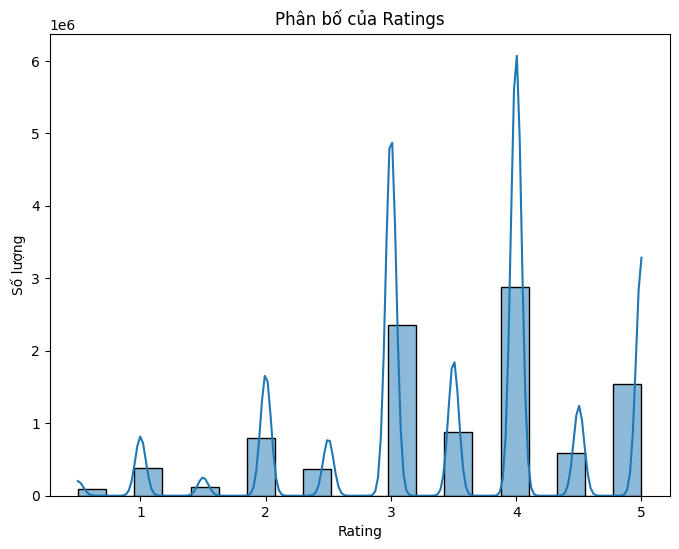

In [7]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.histplot(ratings['rating'], bins=20, kde=True)
plt.xlabel('Rating')
plt.ylabel('Số lượng')
plt.title('Phân bố của Ratings')
plt.show()

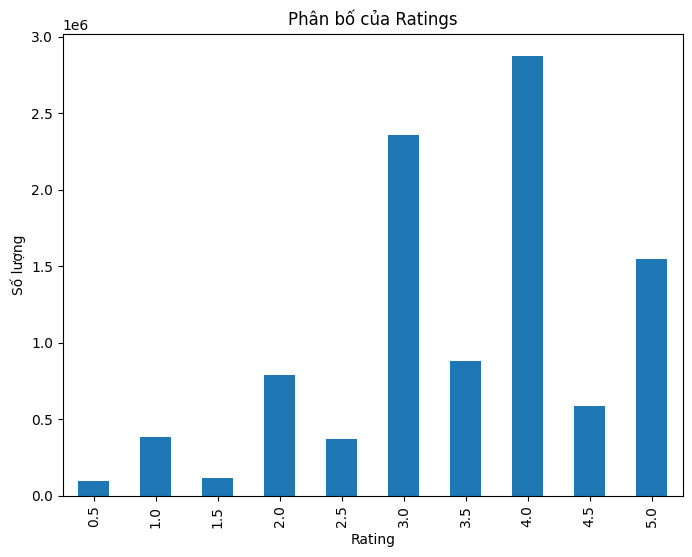

In [8]:
rating_counts = ratings['rating'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
rating_counts.plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Số lượng')
plt.title('Phân bố của Ratings')
plt.show()

In [10]:
# Mã hóa userId và movieId
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
ratings['userId'] = user_encoder.fit_transform(ratings['userId'])
ratings['movieId'] = movie_encoder.fit_transform(ratings['movieId'])
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
print(f"Số lượng users: {num_users}")
print(f"Số lượng movies: {num_movies}")

Số lượng users: 69878
Số lượng movies: 10677


In [11]:
user_positive_matrix = torch.zeros((num_users, num_movies), dtype=torch.bool)
users_tensor = torch.tensor(ratings[ratings['rating']  >=0.5]["userId"].values, dtype=torch.long)
movies_tensor = torch.tensor(ratings[ratings["rating"] >= 0.5]["movieId"].values, dtype=torch.long)
user_positive_matrix[users_tensor, movies_tensor] = True

# Lọc user có mục dương
def filter_users_with_positives(dataframe, user_positive_matrix, num_users):
    valid_users = []
    for user in range(num_users):
        if user_positive_matrix[user].sum() > 0:
            valid_users.append(user)
    filtered_dataframe = dataframe[dataframe["userId"].isin(valid_users)]
    return filtered_dataframe

filtered_ratings = filter_users_with_positives(ratings, user_positive_matrix, num_users)

def check_positive_items_df(dataframe, num_users):
    user_positive_counts = torch.zeros(num_users, device='cpu')
    users = torch.tensor(dataframe["userId"].values, dtype=torch.long)
    user_positive_counts.index_add_(0, users, torch.ones_like(users, dtype=torch.float, device='cpu'))
    print(f"\nNumber of positive items per user (min, max, mean): {user_positive_counts.min().item()}, {user_positive_counts.max().item()}, {user_positive_counts.mean().item()}")
    if user_positive_counts.min().item() == 0:
        print("Warning: Some users have no positive items!")

print("Checking filtered data after LabelEncoder...")
check_positive_items_df(filtered_ratings, num_users)

Checking filtered data after LabelEncoder...

Number of positive items per user (min, max, mean): 20.0, 7359.0, 143.10733032226562


In [12]:
train_val_data, test_data = train_test_split(filtered_ratings, test_size=0.1, random_state=42, stratify=filtered_ratings["userId"])
train_data, val_data = train_test_split(train_val_data, test_size=0.1111, random_state=42, stratify=train_val_data["userId"])
print("Train size:", len(train_data))
print("Validation size:", len(val_data))
print("Test size:", len(test_data))

Train size: 8000142
Validation size: 999906
Test size: 1000006


In [88]:
# Tạo ánh xạ và remap
def create_id_maps(train_df):
    all_users = sorted(train_df['userId'].unique())
    all_movies = sorted(train_df['movieId'].unique())
    user_id_map = {uid: i for i, uid in enumerate(all_users)}
    movie_id_map = {mid: j for j, mid in enumerate(all_movies)}
    return user_id_map, movie_id_map

def remap(df, user_id_map, movie_id_map, handle_unknown='ignore'):
    new_df = df.copy()
    new_df['userId'] = new_df['userId'].map(user_id_map)
    new_df['movieId'] = new_df['movieId'].map(movie_id_map)
    if handle_unknown == 'ignore':
        new_df = new_df.dropna(subset=['userId', 'movieId'])
    new_df['userId'] = new_df['userId'].astype(int)
    new_df['movieId'] = new_df['movieId'].astype(int)
    return new_df

user_id_map, movie_id_map = create_id_maps(train_data)
train_data = remap(train_data, user_id_map, movie_id_map)
val_data = remap(val_data, user_id_map, movie_id_map, handle_unknown='ignore')
test_data = remap(test_data, user_id_map, movie_id_map, handle_unknown='ignore')

# Cập nhật num_users và num_movies
num_users = len(user_id_map)
num_movies = len(movie_id_map)
print(f"Số lượng users (sau remap): {num_users}")
print(f"Số lượng movies (sau remap): {num_movies}")

# Cập nhật user_positive_matrix
user_positive_matrix = torch.zeros((num_users, num_movies), dtype=torch.bool, device=device)
users_tensor = torch.tensor(train_data[train_data["rating"]  >= 0.5]["userId"].values, dtype=torch.long, device=device)
movies_tensor = torch.tensor(train_data[train_data["rating"]  >= 0.5]["movieId"].values, dtype=torch.long, device=device)
user_positive_matrix[users_tensor, movies_tensor] = True

Số lượng users (sau remap): 69878
Số lượng movies (sau remap): 10640


BUILD MODELING

In [13]:
class MovieLensDataset(Dataset):
    def __init__(self, dataframe):
        self.users = torch.tensor(dataframe["userId"].values, dtype=torch.long, device=device)
        self.movies = torch.tensor(dataframe["movieId"].values, dtype=torch.long, device=device)
        self.ratings = torch.tensor(dataframe["rating"].values, dtype=torch.float32, device=device)
        print(f"Dataset ratings - min: {self.ratings.min().item()}, max: {self.ratings.max().item()}")
        if self.ratings.min() < 0.5 or self.ratings.max() > 5.0:
            raise ValueError("Ratings in dataset out of range [0.5, 5.0]")
    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

batch_size = 512
train_dataset = MovieLensDataset(train_data)
val_dataset = MovieLensDataset(val_data)
test_dataset = MovieLensDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Kiểm tra phân phối mục dương
def check_positive_items(data_loader, num_users):
    user_positive_counts = torch.zeros(num_users, device=device)
    for users, _, _ in tqdm(data_loader, desc="Checking positive items"):
        users = users.to(device)
        user_positive_counts.index_add_(0, users, torch.ones_like(users, dtype=torch.float, device=device))
    print(f"Number of positive items per user (min, max, mean): {user_positive_counts.min().item()}, {user_positive_counts.max().item()}, {user_positive_counts.mean().item()}")
    if user_positive_counts.min().item() == 0:
        print("Warning: Some users have no positive items!")

print("Checking train data after splitting...")
check_positive_items(train_loader, num_users)
print("Checking validation data after splitting...")
check_positive_items(val_loader, num_users)
print("Checking test data after splitting...")
check_positive_items(test_loader, num_users)

Dataset ratings - min: 0.5, max: 5.0
Dataset ratings - min: 0.5, max: 5.0
Dataset ratings - min: 0.5, max: 5.0
Checking train data after splitting...


Checking positive items: 100%|██████████| 15626/15626 [01:37<00:00, 160.25it/s]


Number of positive items per user (min, max, mean): 16.0, 5887.0, 114.48727416992188
Checking validation data after splitting...


Checking positive items: 100%|██████████| 1953/1953 [00:11<00:00, 163.08it/s]


Number of positive items per user (min, max, mean): 2.0, 736.0, 14.309309959411621
Checking test data after splitting...


Checking positive items: 100%|██████████| 1954/1954 [00:11<00:00, 164.39it/s]

Number of positive items per user (min, max, mean): 2.0, 736.0, 14.310741424560547


In [14]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:128"

In [15]:
# Định nghĩa Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[1024, 512], latent_dim=256, sparsity_target = 0.1, sparsity_weight = 1e-3):
        super(Autoencoder, self).__init__()
        self.sparsity_target = sparsity_target
        self.sparsity_weight = sparsity_weight
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    def sparsity_loss(self, activations):
        avg_activation = torch.mean(activations, dim=0)
        avg_activation = torch.clamp(avg_activation, min=1e-6, max=1 - 1e-6)
        p = self.sparsity_target
        q = avg_activation
        kl_div = p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q))
        return self.sparsity_weight * torch.sum(kl_div)

In [18]:
def train_autoencoder(autoencoder, data, num_epochs=10, learning_rate=0.0001, device='cpu'):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(autoencoder.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    autoencoder = autoencoder.to(device)
    
    data = data.float().to(device)
    reconstruction_losses = []
    
    for epoch in range(num_epochs):
        autoencoder.train()
        total_loss = 0.0
        num_batches = data.size(0) // 2048 + (1 if data.size(0) % 2048 != 0 else 0)
        
        # Sử dụng tqdm để hiển thị progress bar
        with tqdm(total=num_batches, desc=f"Autoencoder Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for i in range(0, data.size(0), 2048):
                batch = data[i:i+2048].to(device)
                optimizer.zero_grad()
                encoded, reconstructed = autoencoder(batch)
                loss_reconstruction = criterion(reconstructed, batch)
                loss_sparsity = autoencoder.sparsity_loss(encoded)
                loss = loss_reconstruction + loss_sparsity
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)
        
        avg_loss = total_loss / num_batches
        reconstruction_losses.append(avg_loss)
        scheduler.step(avg_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")
    
    print("\nAutoencoder Training Completed!")
    print(f"Final Average Loss: {reconstruction_losses[-1]:.6f}")
    best_loss = min(reconstruction_losses)
    best_epoch = reconstruction_losses.index(best_loss) + 1
    print(f"Best Loss: {best_loss:.6f} (Epoch {best_epoch})")
    
    
    
    return autoencoder

In [19]:
# Huấn luyện Autoencoder trên CPU trước
cpu_device = torch.device("cpu")
autoencoder = Autoencoder(input_dim=num_movies, hidden_dims=[ 1024, 512], latent_dim= 256,sparsity_target = 0.1, sparsity_weight = 1e-3)
print("Starting Autoencoder Training...")
autoencoder = train_autoencoder(autoencoder, user_positive_matrix, num_epochs=10,learning_rate= 0.0001, device=cpu_device)
torch.save(autoencoder.state_dict(), 'autoencoder.pth')
print("Autoencoder Training Saved to 'autoencoder.pth'")

Starting Autoencoder Training...


Autoencoder Epoch 1/10: 100%|██████████| 35/35 [00:49<00:00,  1.43s/batch, loss=0.139]


Epoch 1/10, Average Loss: 0.291162


Autoencoder Epoch 2/10: 100%|██████████| 35/35 [00:49<00:00,  1.41s/batch, loss=0.128]


Epoch 2/10, Average Loss: 0.128805


Autoencoder Epoch 3/10: 100%|██████████| 35/35 [00:49<00:00,  1.40s/batch, loss=0.127]


Epoch 3/10, Average Loss: 0.126521


Autoencoder Epoch 4/10: 100%|██████████| 35/35 [00:48<00:00,  1.39s/batch, loss=0.126]


Epoch 4/10, Average Loss: 0.125855


Autoencoder Epoch 5/10: 100%|██████████| 35/35 [00:48<00:00,  1.38s/batch, loss=0.126]


Epoch 5/10, Average Loss: 0.125462


Autoencoder Epoch 6/10: 100%|██████████| 35/35 [00:47<00:00,  1.36s/batch, loss=0.126]


Epoch 6/10, Average Loss: 0.125295


Autoencoder Epoch 7/10: 100%|██████████| 35/35 [00:48<00:00,  1.39s/batch, loss=0.126]


Epoch 7/10, Average Loss: 0.125170


Autoencoder Epoch 8/10: 100%|██████████| 35/35 [00:49<00:00,  1.41s/batch, loss=0.126]


Epoch 8/10, Average Loss: 0.125067


Autoencoder Epoch 9/10: 100%|██████████| 35/35 [00:49<00:00,  1.40s/batch, loss=0.126]


Epoch 9/10, Average Loss: 0.124979


Autoencoder Epoch 10/10: 100%|██████████| 35/35 [00:47<00:00,  1.35s/batch, loss=0.125]


Epoch 10/10, Average Loss: 0.124881

Autoencoder Training Completed!
Final Average Loss: 0.124881
Best Loss: 0.124881 (Epoch 10)
Autoencoder Training Saved to 'autoencoder.pth'


In [20]:
# Định nghĩa NeuralCF
class NeuralCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=256, layers=[ 256, 128, 64], autoencoder=None):
        super(NeuralCF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        if autoencoder is not None:
            with torch.no_grad():
                batch_size = 512
                print(f"VRAM before user_latent: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
                user_latent = torch.zeros(num_users, embedding_dim, device=device)
                print(f"VRAM after user_latent: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
                user_matrix = user_positive_matrix.cpu()
                for i in range(0, num_users, batch_size):
                    end_idx = min(i + batch_size, num_users)
                    batch_matrix = user_matrix[i:end_idx].float().to(device)
                    latent = autoencoder.encoder(batch_matrix)
                    user_latent[i:end_idx] = latent
                    torch.cuda.empty_cache()
                self.user_embedding.weight.data = user_latent

        mlp_layers_rating = []
        input_size = embedding_dim * 2
        for layer_size in layers:
            mlp_layers_rating.append(nn.Linear(input_size, layer_size))
            mlp_layers_rating.append(nn.BatchNorm1d(layer_size))
            mlp_layers_rating.append(nn.LeakyReLU(0.2))
            mlp_layers_rating.append(nn.Dropout(0.3))
            input_size = layer_size
        self.mlp_rating = nn.Sequential(*mlp_layers_rating)
        self.output_rating = nn.Linear(input_size, 1)

        mlp_layers_ranking = []
        input_size = embedding_dim * 2
        for layer_size in layers:
            mlp_layers_ranking.append(nn.Linear(input_size, layer_size))
            mlp_layers_ranking.append(nn.BatchNorm1d(layer_size))
            mlp_layers_ranking.append(nn.LeakyReLU(0.2))
            mlp_layers_ranking.append(nn.Dropout(0.2))
            input_size = layer_size
        self.mlp_ranking = nn.Sequential(*mlp_layers_ranking)
        self.output_ranking = nn.Linear(input_size, 1)

    def forward(self, user_indices, item_indices):
        user_embedded = self.user_embedding(user_indices)
        item_embedded = self.item_embedding(item_indices)
        context = torch.cat([user_embedded, item_embedded], dim=-1)
        rating_output = self.mlp_rating(context)
        rating_output = self.output_rating(rating_output)
        ranking_output = self.mlp_ranking(context)
        ranking_output = self.output_ranking(ranking_output)
        return rating_output, ranking_output

In [23]:
def hard_negative_sampling(user_ids, model, device, num_movies, num_negatives=50, user_positive_matrix=None, max_candidates=256):
  
    model.eval()
    batch_size = user_ids.size(0)
    with torch.no_grad(), torch.amp.autocast('cuda', dtype=torch.float16):
        all_movies = torch.arange(num_movies, device=device, dtype=torch.long)
        # Nếu có user_positive_matrix, ta tạo mask để loại bỏ các item đã tương tác
        if user_positive_matrix is not None:
            mask = ~user_positive_matrix[user_ids].to(device)  # True cho các item chưa tương tác
            candidate_indices = torch.where(mask.any(dim=0))[0]
            if candidate_indices.size(0) > max_candidates:
                candidate_indices = candidate_indices[torch.randperm(candidate_indices.size(0), device=device)[:max_candidates]]
            candidate_movies = all_movies[candidate_indices]
        else:
            candidate_movies = all_movies
        
        if candidate_movies.size(0) < num_negatives:
            neg_indices = candidate_movies[torch.randperm(candidate_movies.size(0), device=device)[:min(num_negatives, candidate_movies.size(0))]]
            return neg_indices.unsqueeze(0).repeat(batch_size, 1)
        
        num_candidates = candidate_movies.size(0)
        repeated_users = user_ids.repeat_interleave(num_candidates)
        repeated_movies = candidate_movies.repeat(batch_size)
        _, scores = model(repeated_users, repeated_movies)
        scores = scores.squeeze(-1).view(batch_size, num_candidates)
        if user_positive_matrix is not None:
            candidate_mask = mask[:, candidate_movies]
            masked_scores = scores * candidate_mask.float()
        else:
            masked_scores = scores
        neg_indices = torch.topk(masked_scores, min(num_negatives, num_candidates), dim=1).indices
        return candidate_movies[neg_indices]

In [32]:
def combined_loss(rating_preds, ratings, pos_ranking, neg_ranking, model, lambda_reg=1e-6, ranking_weight = 1.0, device = 'cuda'):
  
    # Rating loss
    criterion_rating = nn.MSELoss().to(device)
    rating_loss = criterion_rating(rating_preds, ratings)
    if torch.isnan(rating_loss) or torch.isinf(rating_loss):
        print("Warning: rating_loss is NaN or inf!")

    # Ranking loss
    criterion_margin = nn.MarginRankingLoss(margin=1.0).to(device)
    pos_expanded = pos_ranking.unsqueeze(1).expand(-1, neg_ranking.size(1))
    target = torch.ones_like(neg_ranking, device=device)
    ranking_loss = criterion_margin(pos_expanded, neg_ranking, target) 
    if torch.isnan(ranking_loss) or torch.isinf(ranking_loss):
        print("Warning: ranking_loss is NaN or inf!")
        print(f"pos_ranking: {pos_ranking[:5]}, neg_ranking: {neg_ranking[:5]}")

    # Regularization
    reg_loss = 0.0
    for param in model.parameters():
        reg_loss += (param ** 2).sum()
    if torch.isnan(reg_loss) or torch.isinf(reg_loss):
        print("Warning: reg_loss is NaN or inf!")
    total_loss = rating_loss + ranking_weight * ranking_loss + lambda_reg * reg_loss

    return total_loss ,rating_loss, ranking_loss, reg_loss

In [33]:


def get_sample_predictions(model, users, positive_movies, negative_movies, device):
    model.eval()
    with torch.no_grad():
        batch_size = users.shape[0]
        num_negatives = negative_movies.shape[1]
        pos_rating, pos_ranking = model(users, positive_movies)
        neg_users = users.repeat_interleave(num_negatives)
        neg_movies = negative_movies.view(-1)
        neg_rating, neg_ranking = model(neg_users, neg_movies)
        neg_rating = neg_rating.view(batch_size, num_negatives)
        neg_ranking = neg_ranking.view(batch_size, num_negatives)
        all_ratings = torch.cat([pos_rating, neg_rating], dim=1)
        all_rankings = torch.cat([pos_ranking, neg_ranking], dim=1)
    return all_ratings, all_rankings

In [34]:
def evaluate_model(model, data_loader, device, num_movies, k=20, num_negatives=50, 
                   user_positive_matrix=None, rating_threshold=3.0):
    model.eval()
    total_mse, total_mae = 0.0, 0.0
    num_batches = 0
    
    # Các metric retrieval – bạn cần cài đặt hoặc import các class này
    precision_metric = RetrievalPrecision(top_k=k).to(device)
    recall_metric = RetrievalRecall(top_k=k).to(device)
    mrr_metric = RetrievalMRR(top_k=k).to(device)
    ndcg_metric = RetrievalNormalizedDCG(top_k=k).to(device)
    
    with torch.no_grad():
        for users, movies, ratings in tqdm(data_loader, desc="Evaluating"):
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            negative_movies = hard_negative_sampling(users, model, device, num_movies, 
                                                     num_negatives, user_positive_matrix)
            batch_ratings, batch_rankings = get_sample_predictions(model, users, movies, negative_movies, device)
            preds_rating = batch_ratings[:, 0]
            mse = F.mse_loss(preds_rating, ratings).item()
            mae = torch.abs(preds_rating - ratings).mean().item()
            total_mse += mse
            total_mae += mae
            batch_size = users.size(0)
            # Sử dụng ngưỡng cố định hoặc tính trên batch
            true_labels = torch.zeros((batch_size, num_negatives + 1), device=device, dtype=torch.float32)
            true_labels[:, 0] = (ratings >= rating_threshold).float()
            indexes = torch.arange(batch_size, device=device).repeat_interleave(num_negatives + 1)
            batch_rankings_flat = batch_rankings.view(-1)
            true_labels_flat = true_labels.view(-1)
            
            if true_labels_flat.sum() > 0:
                precision_metric.update(batch_rankings_flat, true_labels_flat, indexes)
                recall_metric.update(batch_rankings_flat, true_labels_flat, indexes)
                mrr_metric.update(batch_rankings_flat, true_labels_flat, indexes)
                ndcg_metric.update(batch_rankings_flat, true_labels_flat, indexes)
            num_batches += 1
            # Có thể bỏ lệnh empty_cache nếu không gặp vấn đề bộ nhớ
            torch.cuda.empty_cache()
    
    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches
    rmse = avg_mse ** 0.5
    avg_precision = precision_metric.compute().item()
    avg_recall = recall_metric.compute().item()
    avg_mrr = mrr_metric.compute().item()
    avg_ndcg = ndcg_metric.compute().item()
    
    precision_metric.reset()
    recall_metric.reset()
    mrr_metric.reset()
    ndcg_metric.reset()
    
    return rmse, avg_mae, avg_precision, avg_recall, avg_mrr, avg_ndcg

In [35]:
!nvidia-smi

Sat Mar 15 02:33:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   78C    P0             34W /   70W |    2771MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
torch.cuda.memory_allocated()

1874695680

In [37]:
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10677, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10677, bias=True)
    (5): Sigmoid()
  )
)

In [38]:
# Huấn luyện NeuralCF
torch.cuda.empty_cache()
print(f"VRAM before NeuralCF: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
autoencoder.to(device)
model = NeuralCF(num_users, num_movies, embedding_dim=256, autoencoder=autoencoder).to(device)
print(f"VRAM after NeuralCF: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
user_positive_matrix = user_positive_matrix.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.amp.GradScaler('cuda')
    
num_epochs = 15
patience = 10
epochs_no_improve = 0
best_val_rating_loss = float('inf')  # Dùng rating_loss để đánh giá
best_model_state = None
    
rating_losses_train = []
ranking_losses_train = []
reg_losses_train = []
rating_losses_val = []
ranking_losses_val = []
reg_losses_val = []
    
    # Kiểm tra phân phối ratings trên train
all_ratings = torch.cat([r for _, _, r in train_loader], dim=0).cpu().numpy()
print(f"Train Rating distribution: min={all_ratings.min()}, max={all_ratings.max()}, mean={all_ratings.mean()}")
    
for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        model.train()
        total_train_rating_loss = 0.0
        total_train_ranking_loss = 0.0
        total_train_reg_loss = 0.0
        total_train_loss = 0.0
        
        # Số lượng negatives có thể tăng dần theo epoch
        num_negatives = min(20 + epoch * 5, 50)
        
        # Trọng số động: alpha cho ranking, beta cho rating
        alpha = 0.5 + (2.5 - 0.5) * (epoch / (num_epochs - 1))
        beta = 1.0 - (epoch / (num_epochs - 1)) * 0.4
        
        for users, movies, ratings in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                rating_preds, ranking_preds = model(users, movies)
                # Lấy negatives cho ranking
                negative_movies = hard_negative_sampling(users, model, device, num_users, 
                                                         num_negatives=num_negatives, user_positive_matrix=user_positive_matrix, max_candidates=256)
                neg_users = users.repeat_interleave(num_negatives)
                neg_movies = negative_movies.view(-1)
                _, neg_ranking = model(neg_users, neg_movies)
                neg_ranking = neg_ranking.view(users.size(0), num_negatives)
                
                if torch.isnan(ranking_preds).any() or torch.isnan(neg_ranking).any():
                    print("NaN detected in ranking predictions!")
                    break
                
                loss, loss_rating, loss_ranking, reg_loss = combined_loss(
                    rating_preds.squeeze(), ratings, ranking_preds.squeeze(), neg_ranking.squeeze(),
                    model, lambda_reg=1e-6, ranking_weight=alpha, device=device
                )
                # Tổng loss được tính theo trọng số động: beta cho rating_loss
                total_loss = beta * loss_rating + alpha * loss_ranking + 1e-6 * reg_loss
            if torch.isnan(total_loss) or torch.isinf(total_loss):
                print("Warning: Total loss is NaN or Inf!")
                break
            scaler.scale(total_loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            total_train_rating_loss += loss_rating.item()
            total_train_ranking_loss += loss_ranking.item()
            total_train_reg_loss += reg_loss.item()
            total_train_loss += total_loss.item()
        
        avg_train_rating_loss = total_train_rating_loss / len(train_loader)
        avg_train_ranking_loss = total_train_ranking_loss / len(train_loader)
        avg_train_reg_loss = total_train_reg_loss / len(train_loader)
        rating_losses_train.append(avg_train_rating_loss)
        ranking_losses_train.append(avg_train_ranking_loss)
        reg_losses_train.append(avg_train_reg_loss)
        
        # Validation
        model.eval()
        total_val_rating_loss = 0.0
        total_val_ranking_loss = 0.0
        total_val_reg_loss = 0.0
        with torch.no_grad():
            for users, movies, ratings in tqdm(val_loader, desc=f"Epoch {epoch+1} [Validation]"):
                users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                    rating_preds, ranking_preds = model(users, movies)
                    negative_movies = hard_negative_sampling(users, model, device, num_users, 
                                                            num_negatives=num_negatives, user_positive_matrix=user_positive_matrix, max_candidates=256)
                    neg_users = users.repeat_interleave(num_negatives)
                    neg_movies = negative_movies.view(-1)
                    _, neg_ranking = model(neg_users, neg_movies)
                    neg_ranking = neg_ranking.view(users.size(0), num_negatives)
                    loss, loss_rating, loss_ranking, reg_loss = combined_loss(
                        rating_preds.squeeze(), ratings, ranking_preds.squeeze(), neg_ranking.squeeze(),
                        model, lambda_reg=1e-6, ranking_weight=alpha, device=device
                    )
                total_val_rating_loss += loss_rating.item()
                total_val_ranking_loss += loss_ranking.item()
                total_val_reg_loss += reg_loss.item()
        avg_val_rating_loss = total_val_rating_loss / len(val_loader)
        avg_val_ranking_loss = total_val_ranking_loss / len(val_loader)
        rating_losses_val.append(avg_val_rating_loss)
        ranking_losses_val.append(avg_val_ranking_loss)
        reg_losses_val.append(total_val_reg_loss / len(val_loader))
        
        # Đánh giá retrieval metrics trên validation
        rmse_val, mae_val, precision_val, recall_val, mrr_val, ndcg_val = evaluate_model(
            model, val_loader, device, num_users, k=20, num_negatives=num_negatives, user_positive_matrix=user_positive_matrix, rating_threshold=3.0
        )
        
        print(f"Epoch {epoch+1} | Train Rating Loss: {avg_train_rating_loss:.4f} | Train Ranking Loss: {avg_train_ranking_loss:.4f} | Train Reg Loss: {avg_train_reg_loss:.4f}")
        print(f"Epoch {epoch+1} | Val Rating Loss: {avg_val_rating_loss:.4f} | Val Ranking Loss: {avg_val_ranking_loss:.4f}")
        print(f"Val RMSE: {rmse_val:.4f} | Val MAE: {mae_val:.4f}")
        print(f"Val Precision@20: {precision_val:.4f} | Val Recall@20: {recall_val:.4f}")
        print(f"Val MRR@20: {mrr_val:.4f} | Val NDCG@20: {ndcg_val:.4f}")
        
        # Early stopping dựa trên Val Rating Loss
        if avg_val_rating_loss < best_val_rating_loss:
            best_val_rating_loss = avg_val_rating_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict().copy()
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'rating_losses_train': rating_losses_train,
                'ranking_losses_train': ranking_losses_train,
                'reg_losses_train': reg_losses_train,
                'rating_losses_val': rating_losses_val,
                'ranking_losses_val': ranking_losses_val,
                'reg_losses_val': reg_losses_val,
            }, f'checkpoint_epoch_{epoch+1}.pth')
            print("Best model updated (based on Val Rating Loss)!")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        scheduler.step(avg_val_rating_loss)
    
model.load_state_dict(best_model_state)
print("\nLoaded the best model for final evaluation on test set")
rmse_test, mae_test, precision_test, recall_test, mrr_test, ndcg_test = evaluate_model(
        model, test_loader, device, num_users, k=20, num_negatives=50, user_positive_matrix=user_positive_matrix, rating_threshold=3.0
    )
print(f"Test RMSE: {rmse_test:.4f} | Test MAE: {mae_test:.4f}")
print(f"Test Precision@10: {precision_test:.4f} | Test Recall@10: {recall_test:.4f}")
print(f"Test MRR@10: {mrr_test:.4f} | Test NDCG@10: {ndcg_test:.4f}")


VRAM before NeuralCF: 1.75 GB
VRAM before user_latent: 1.75 GB
VRAM after user_latent: 1.81 GB
VRAM after NeuralCF: 1.82 GB
Train Rating distribution: min=0.5, max=5.0, mean=3.512730836868286


Evaluating: 100%|██████████| 1953/1953 [01:20<00:00, 24.32it/s]


Epoch 1 | Train Rating Loss: 0.8104 | Train Ranking Loss: 0.8980 | Train Reg Loss: 11336631.7752
Epoch 1 | Val Rating Loss: 0.7530 | Val Ranking Loss: 0.8069
Val RMSE: 0.8677 | Val MAE: 0.6715
Val Precision@20: 0.7398 | Val Recall@20: 0.0092
Val MRR@20: 0.9346 | Val NDCG@20: 0.7649
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:21<00:00, 24.00it/s]


Epoch 2 | Train Rating Loss: 0.7341 | Train Ranking Loss: 0.7865 | Train Reg Loss: 8662240.6133
Epoch 2 | Val Rating Loss: 0.7212 | Val Ranking Loss: 0.8311
Val RMSE: 0.8492 | Val MAE: 0.6527
Val Precision@20: 0.4027 | Val Recall@20: 0.0050
Val MRR@20: 0.6726 | Val NDCG@20: 0.4162
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:25<00:00, 22.80it/s]


Epoch 3 | Train Rating Loss: 0.7044 | Train Ranking Loss: 0.7285 | Train Reg Loss: 6674063.1993
Epoch 3 | Val Rating Loss: 0.7026 | Val Ranking Loss: 0.6553
Val RMSE: 0.8382 | Val MAE: 0.6477
Val Precision@20: 0.7896 | Val Recall@20: 0.0098
Val MRR@20: 0.9649 | Val NDCG@20: 0.8155
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:25<00:00, 22.86it/s]


Epoch 4 | Train Rating Loss: 0.6873 | Train Ranking Loss: 0.6162 | Train Reg Loss: 5059558.1585
Epoch 4 | Val Rating Loss: 0.6916 | Val Ranking Loss: 0.6018
Val RMSE: 0.8316 | Val MAE: 0.6396
Val Precision@20: 0.8029 | Val Recall@20: 0.0100
Val MRR@20: 0.9691 | Val NDCG@20: 0.8280
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:26<00:00, 22.69it/s]


Epoch 5 | Train Rating Loss: 0.6710 | Train Ranking Loss: 0.5558 | Train Reg Loss: 3802073.5405
Epoch 5 | Val Rating Loss: 0.6814 | Val Ranking Loss: 0.5407
Val RMSE: 0.8255 | Val MAE: 0.6345
Val Precision@20: 0.8052 | Val Recall@20: 0.0100
Val MRR@20: 0.9688 | Val NDCG@20: 0.8294
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:27<00:00, 22.31it/s]


Epoch 6 | Train Rating Loss: 0.6561 | Train Ranking Loss: 0.4947 | Train Reg Loss: 2891270.2598
Epoch 6 | Val Rating Loss: 0.6702 | Val Ranking Loss: 0.4789
Val RMSE: 0.8186 | Val MAE: 0.6272
Val Precision@20: 0.8081 | Val Recall@20: 0.0100
Val MRR@20: 0.9648 | Val NDCG@20: 0.8321
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:28<00:00, 21.94it/s]


Epoch 7 | Train Rating Loss: 0.6431 | Train Ranking Loss: 0.4392 | Train Reg Loss: 2236618.3349
Epoch 7 | Val Rating Loss: 0.6642 | Val Ranking Loss: 0.4287
Val RMSE: 0.8149 | Val MAE: 0.6256
Val Precision@20: 0.8132 | Val Recall@20: 0.0101
Val MRR@20: 0.9624 | Val NDCG@20: 0.8357
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:28<00:00, 21.94it/s]


Epoch 8 | Train Rating Loss: 0.6273 | Train Ranking Loss: 0.4115 | Train Reg Loss: 1847447.3244
Epoch 8 | Val Rating Loss: 0.6572 | Val Ranking Loss: 0.4061
Val RMSE: 0.8107 | Val MAE: 0.6218
Val Precision@20: 0.8320 | Val Recall@20: 0.0103
Val MRR@20: 0.9707 | Val NDCG@20: 0.8533
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:28<00:00, 22.02it/s]


Epoch 9 | Train Rating Loss: 0.6201 | Train Ranking Loss: 0.3913 | Train Reg Loss: 1523949.6662
Epoch 9 | Val Rating Loss: 0.6543 | Val Ranking Loss: 0.3882
Val RMSE: 0.8089 | Val MAE: 0.6190
Val Precision@20: 0.8263 | Val Recall@20: 0.0103
Val MRR@20: 0.9567 | Val NDCG@20: 0.8442
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:29<00:00, 21.81it/s]


Epoch 10 | Train Rating Loss: 0.6093 | Train Ranking Loss: 0.3740 | Train Reg Loss: 1253747.3155
Epoch 10 | Val Rating Loss: 0.6499 | Val Ranking Loss: 0.3749
Val RMSE: 0.8062 | Val MAE: 0.6170
Val Precision@20: 0.8168 | Val Recall@20: 0.0102
Val MRR@20: 0.9499 | Val NDCG@20: 0.8348
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:28<00:00, 22.10it/s]


Epoch 11 | Train Rating Loss: 0.6005 | Train Ranking Loss: 0.3608 | Train Reg Loss: 1024605.6855
Epoch 11 | Val Rating Loss: 0.6491 | Val Ranking Loss: 0.3695
Val RMSE: 0.8057 | Val MAE: 0.6183
Val Precision@20: 0.8114 | Val Recall@20: 0.0101
Val MRR@20: 0.9438 | Val NDCG@20: 0.8269
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:29<00:00, 21.94it/s]


Epoch 12 | Train Rating Loss: 0.5955 | Train Ranking Loss: 0.3497 | Train Reg Loss: 805989.3261
Epoch 12 | Val Rating Loss: 0.6422 | Val Ranking Loss: 0.3564
Val RMSE: 0.8014 | Val MAE: 0.6168
Val Precision@20: 0.8320 | Val Recall@20: 0.0103
Val MRR@20: 0.9543 | Val NDCG@20: 0.8496
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:34<00:00, 20.72it/s]


Epoch 13 | Train Rating Loss: 0.5830 | Train Ranking Loss: 0.3356 | Train Reg Loss: 618101.1838
Epoch 13 | Val Rating Loss: 0.6410 | Val Ranking Loss: 0.3418
Val RMSE: 0.8006 | Val MAE: 0.6165
Val Precision@20: 0.8369 | Val Recall@20: 0.0104
Val MRR@20: 0.9674 | Val NDCG@20: 0.8569
Best model updated (based on Val Rating Loss)!


Evaluating: 100%|██████████| 1953/1953 [01:29<00:00, 21.85it/s]


Epoch 14 | Train Rating Loss: 0.5690 | Train Ranking Loss: 0.3232 | Train Reg Loss: 481464.4610
Epoch 14 | Val Rating Loss: 0.6416 | Val Ranking Loss: 0.3343
Val RMSE: 0.8010 | Val MAE: 0.6104
Val Precision@20: 0.8425 | Val Recall@20: 0.0105
Val MRR@20: 0.9655 | Val NDCG@20: 0.8625


Evaluating: 100%|██████████| 1953/1953 [01:29<00:00, 21.86it/s]


Epoch 15 | Train Rating Loss: 0.5549 | Train Ranking Loss: 0.3132 | Train Reg Loss: 383926.1988
Epoch 15 | Val Rating Loss: 0.6373 | Val Ranking Loss: 0.3283
Val RMSE: 0.7983 | Val MAE: 0.6094
Val Precision@20: 0.8352 | Val Recall@20: 0.0104
Val MRR@20: 0.9557 | Val NDCG@20: 0.8537
Best model updated (based on Val Rating Loss)!

Loaded the best model for final evaluation on test set


Evaluating: 100%|██████████| 1954/1954 [01:29<00:00, 21.95it/s]


Test RMSE: 0.7971 | Test MAE: 0.6085
Test Precision@10: 0.8428 | Test Recall@10: 0.0105
Test MRR@10: 0.9652 | Test NDCG@10: 0.8599


Mô hình hội tụ khá tốt với epoch 15

<ipython-input-42-0a2e078934c3>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


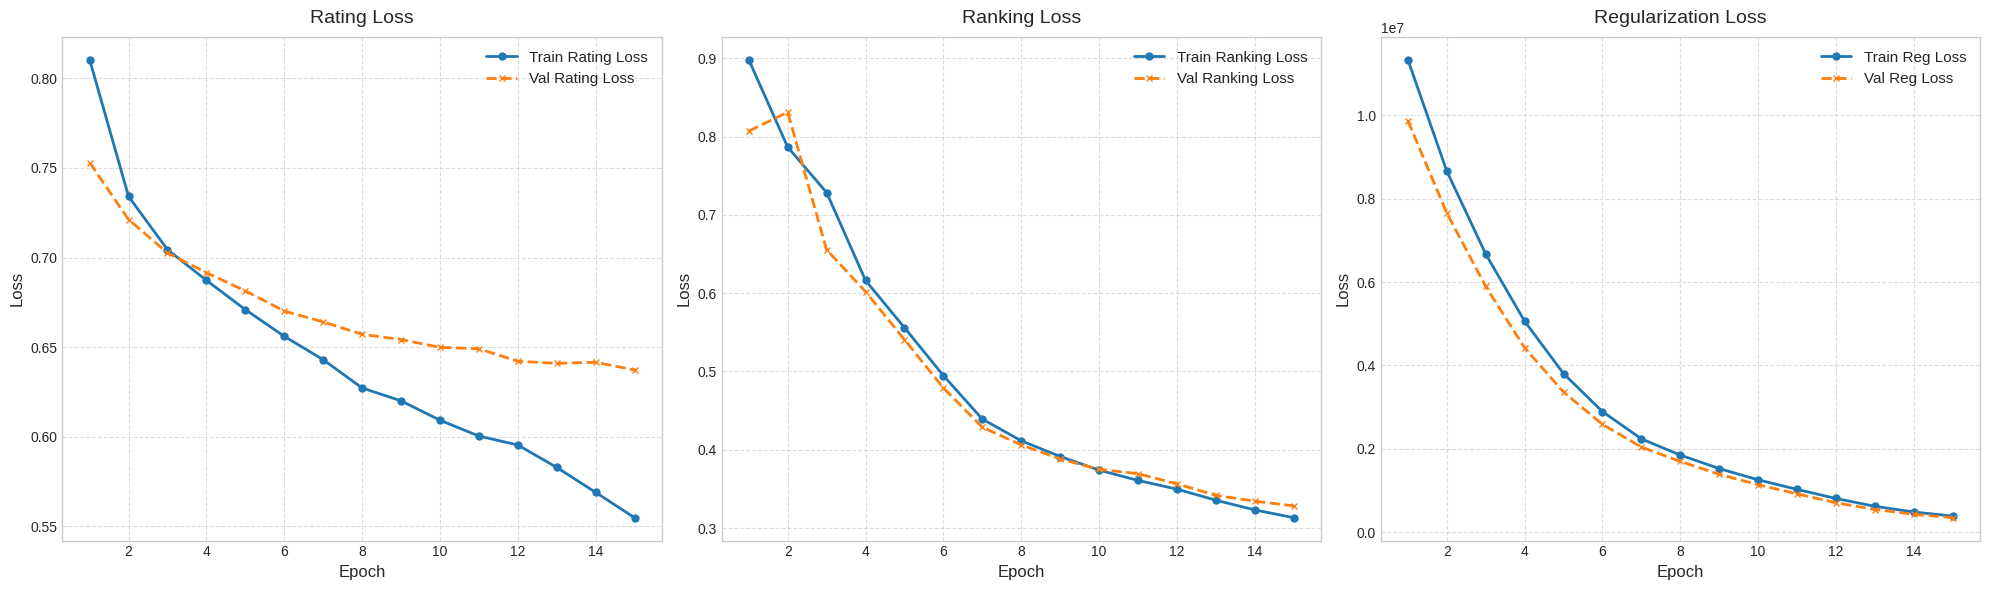

In [42]:


epochs_range = range(1, len(rating_losses_train) + 1)

plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- Biểu đồ 1: Rating Loss ---
axes[0].plot(epochs_range, rating_losses_train, marker='o', color='tab:blue',
             label='Train Rating Loss', linewidth=2, markersize=5)
axes[0].plot(epochs_range, rating_losses_val, marker='x', color='tab:orange',
             label='Val Rating Loss', linewidth=2, markersize=5, linestyle='--')
axes[0].set_title('Rating Loss', fontsize=14, pad=10)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11, loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.7)

# --- Biểu đồ 2: Ranking Loss ---
axes[1].plot(epochs_range, ranking_losses_train, marker='o', color='tab:blue',
             label='Train Ranking Loss', linewidth=2, markersize=5)
axes[1].plot(epochs_range, ranking_losses_val, marker='x', color='tab:orange',
             label='Val Ranking Loss', linewidth=2, markersize=5, linestyle='--')
axes[1].set_title('Ranking Loss', fontsize=14, pad=10)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11, loc='upper right')
axes[1].grid(True, linestyle='--', alpha=0.7)

# --- Biểu đồ 3: Regularization Loss ---
axes[2].plot(epochs_range, reg_losses_train, marker='o', color='tab:blue',
             label='Train Reg Loss', linewidth=2, markersize=5)
axes[2].plot(epochs_range, reg_losses_val, marker='x', color='tab:orange',
             label='Val Reg Loss', linewidth=2, markersize=5, linestyle='--')
axes[2].set_title('Regularization Loss', fontsize=14, pad=10)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Loss', fontsize=12)
axes[2].legend(fontsize=11, loc='upper right')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('train_val_losses.png', dpi=300, bbox_inches='tight')
plt.show()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


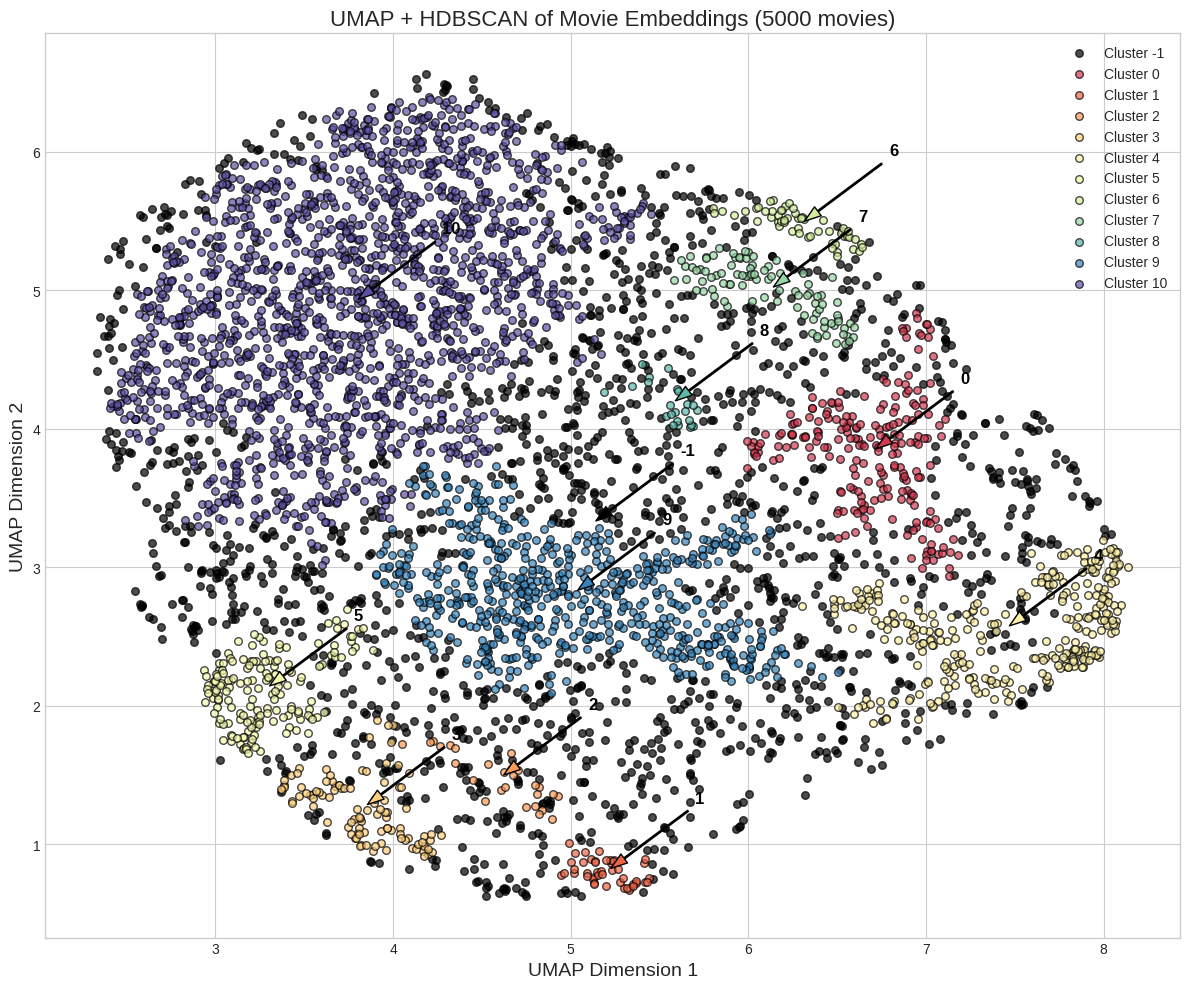

In [77]:
import umap
import hdbscan
import matplotlib.pyplot as plt
import numpy as np

def visualize_embeddings(model, num_samples=5000, random_state=42):
    # Lấy embeddings của item (movie)
    movie_emb = model.item_embedding.weight.data.cpu().numpy()
    if num_samples > movie_emb.shape[0]:
        num_samples = movie_emb.shape[0]
    rng = np.random.default_rng(random_state)
    indices = rng.choice(movie_emb.shape[0], size=num_samples, replace=False)
    sampled_emb = movie_emb[indices]
    
    # Giảm chiều embeddings xuống 2D bằng UMAP
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.01, 
                        metric='cosine', random_state=random_state)
    emb_2d = reducer.fit_transform(sampled_emb)
    
    # Phân cụm với HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=20, gen_min_span_tree=True)
    cluster_labels = clusterer.fit_predict(emb_2d)
    
    # Chuẩn bị vẽ đồ thị
    plt.figure(figsize=(12, 10))
    unique_labels = np.unique(cluster_labels)
    # Dùng colormap "Spectral" để lấy dải màu
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        # Cụm -1 là noise, ta cho màu đen
        if k == -1:
            col = [0, 0, 0, 1]
        class_member_mask = (cluster_labels == k)
        xy = emb_2d[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], s=30, c=[col], alpha=0.7, edgecolor='k', label=f'Cluster {k}')
        
        # Tính tâm cụm nếu số lượng điểm > 0
        if xy.shape[0] > 0:
            centroid = np.mean(xy, axis=0)
            plt.annotate(f'{k}', xy=centroid, xytext=(centroid[0]+0.5, centroid[1]+0.5),
                         fontsize=12, fontweight='bold', color='black',
                         arrowprops=dict(facecolor=col, shrink=0.05, width=1, headwidth=8))
    
    plt.title(f"UMAP + HDBSCAN of Movie Embeddings ({num_samples} movies)", fontsize=16)
    plt.xlabel("UMAP Dimension 1", fontsize=14)
    plt.ylabel("UMAP Dimension 2", fontsize=14)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

# Gọi hàm với model đã được huấn luyện
visualize_embeddings(model, num_samples=5000, random_state=42)


In [89]:
# Đọc file movies.dat với các cột được đặt tên
movies = pd.read_csv(f"{dataset_path}/movies.dat", sep="::", engine="python",
                     names=["movieId", "title", "genres"])

# Loại bỏ các dòng thiếu movieId và chuyển đổi movieId về kiểu số nguyên
movies.dropna(subset=["movieId"], inplace=True)
movies["movieId"] = movies["movieId"].astype(int)

# Lọc các movieId có trong cả movie_encoder.classes_ và movie_id_map.keys()
valid_movie_ids = set(movie_encoder.classes_) & set(movie_id_map.keys())
movies = movies[movies["movieId"].isin(valid_movie_ids)].copy()

# Chuyển đổi movieId bằng vector hóa và sau đó map với movie_id_map
movies["movieId"] = movie_encoder.transform(movies["movieId"])
movies["movieId"] = movies["movieId"].map(movie_id_map)

# Tạo cột kết hợp gồm title và genres để dùng cho tìm kiếm TF-IDF
movies['combined'] = movies['title'] + " " + movies['genres']

# Tính toán ma trận TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['combined'])
print("Shape of TF-IDF matrix:", tfidf_matrix.shape)


Shape of TF-IDF matrix: (8303, 8427)


In [112]:
import inspect

async def correct_query(query: str) -> str:
    """
    Phát hiện ngôn ngữ, dịch sang tiếng Anh nếu cần và hiệu chỉnh chính tả của truy vấn.
    """
    loop = asyncio.get_running_loop()
    try:
        lang = await loop.run_in_executor(None, detect, query)
    except Exception:
        lang = "en"
    
    if lang != "en":
        # Kiểm tra xem translator.translate có phải là hàm bất đồng bộ không
        if inspect.iscoroutinefunction(translator.translate):
            translation = await translator.translate(query, dest='en')
        else:
            translation = await loop.run_in_executor(None, lambda: translator.translate(query, dest='en'))
        query = translation.text

    spell = SpellChecker(language='en')
    words = query.split()
    corrected_words = [spell.correction(word) or word for word in words]
    corrected_query = " ".join(corrected_words)
    return corrected_query


async def search_movies(query: str, top_k: int = 5) -> list:
    """
    Tìm kiếm phim dựa trên truy vấn đã hiệu chỉnh bằng TF-IDF và cosine similarity.
    """
    corrected = await correct_query(query)
    print("Corrected query:", corrected)
    query_vec = tfidf_vectorizer.transform([corrected])
    cos_sim = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = cos_sim.argsort()[-top_k:][::-1]
    results = movies.iloc[top_indices][['movieId', 'title', 'genres']].values.tolist()
    return results

def suggest_movies(partial_query: str, top_k: int = 5) -> list:
    """
    Đề xuất phim dựa trên truy vấn một phần (partial query) so khớp với tiêu đề phim.
    """
    partial_lower = partial_query.lower()
    suggestions = movies[movies['title'].str.lower().str.contains(partial_lower)]
    return suggestions[['movieId', 'title']].head(top_k).values.tolist()

async def search_by_emotion(query: str, top_k: int = 5) -> list:
    """
    Tìm kiếm phim dựa trên từ khóa cảm xúc (như "buồn", "vui", "hành động", "kinh dị").
    Nếu không phát hiện cảm xúc rõ ràng, sử dụng tìm kiếm mặc định.
    """
    query_lower = query.lower()
    if "buồn" in query_lower:
        filtered = movies[movies['genres'].str.contains("Drama|Romance", case=False, regex=True)]
    elif "vui" in query_lower:
        filtered = movies[movies['genres'].str.contains("Comedy", case=False)]
    elif "hành động" in query_lower:
        filtered = movies[movies['genres'].str.contains("Action", case=False)]
    elif "kinh dị" in query_lower:
        filtered = movies[movies['genres'].str.contains("Horror", case=False)]
    else:
        print("No explicit emotion detected, using default search.")
        return await search_movies(query, top_k)
    
    # Sử dụng truy vấn gốc để tạo vector TF-IDF (có thể cân nhắc dùng truy vấn đã hiệu chỉnh nếu cần)
    filtered_matrix = tfidf_vectorizer.transform(filtered['combined'])
    query_vec = tfidf_vectorizer.transform([query])
    cos_sim = cosine_similarity(query_vec, filtered_matrix).flatten()
    top_indices = cos_sim.argsort()[-top_k:][::-1]
    results = filtered.iloc[top_indices][['movieId', 'title', 'genres']].values.tolist()
    return results


In [109]:

from typing import List, Tuple, Any

# Pre-compile regex for release year extraction for better performance
YEAR_REGEX = re.compile(r'\((\d{4})\)')

def extract_release_year(title: str) -> float:
    """
    Extract the release year from a movie title.
    If no year is found, returns np.nan.
    """
    match = YEAR_REGEX.search(title)
    if match:
        return int(match.group(1))
    return np.nan

def get_new_releases(movies_df: pd.DataFrame, top_k: int = 5, recent_years: int = 1) -> List[List[Any]]:
    """
    Return a list of new release movies from the last `recent_years`.
    If the 'release_year' column does not exist, it is computed from the title.
    Movies are sorted by release_year in descending order.
    
    Parameters:
        movies_df (pd.DataFrame): DataFrame containing movie data.
        top_k (int): Number of top movies to return.
        recent_years (int): Number of recent years to consider.
    
    Returns:
        List of movies with columns [movieId, title, genres, release_year].
    """
    # Tránh sửa đổi trực tiếp DataFrame gốc
    df = movies_df.copy()
    if 'release_year' not in df.columns:
        df['release_year'] = df['title'].apply(extract_release_year)
    
    current_year = datetime.now().year
    threshold_year = current_year - recent_years
    new_releases = df[df['release_year'].notna() & (df['release_year'] >= threshold_year)].copy()
    new_releases = new_releases.sort_values(by='release_year', ascending=False)
    
    return new_releases[['movieId', 'title', 'genres', 'release_year']].head(top_k).values.tolist()

def display_watched_movies(user_id: int, movies_df: pd.DataFrame, watched_data: dict) -> List[Tuple[int, str, int]]:
    """
    Return a list of watched movies for a given user.
    Mỗi phần tử trả về là tuple: (movieId, title, progress).
    
    Parameters:
        user_id (int): The user's ID.
        movies_df (pd.DataFrame): DataFrame containing movie data.
        watched_data (dict): Dictionary mapping user_id to list of tuples (movieId, progress).
    
    Returns:
        List of tuples (movieId, title, progress). Nếu không có lịch sử, trả về danh sách rỗng.
    """
    if user_id not in watched_data or not watched_data[user_id]:
        print("Người dùng chưa có lịch sử xem phim.")
        return []
    
    # Sử dụng tra cứu nhanh nếu movies_df chưa được index theo movieId
    if 'movieId' not in movies_df.index.names:
        movie_lookup = movies_df.set_index('movieId')
    else:
        movie_lookup = movies_df

    result = []
    for movieId, progress in watched_data[user_id]:
        if movieId in movie_lookup.index:
            title = movie_lookup.loc[movieId, 'title']
            result.append((movieId, title, progress))
    return result

def continue_watching(user_id: int, movies_df: pd.DataFrame, watched_data: dict) -> List[Tuple[int, str, int]]:
    """
    Return a list of movies that the user has started watching but chưa hoàn thành (progress < 100).
    
    Parameters:
        user_id (int): The user's ID.
        movies_df (pd.DataFrame): DataFrame containing movie data.
        watched_data (dict): Dictionary mapping user_id to list of tuples (movieId, progress).
    
    Returns:
        List of tuples (movieId, title, progress) cho những phim chưa xem xong.
    """
    watched = display_watched_movies(user_id, movies_df, watched_data)
    continue_list = [movie for movie in watched if movie[2] < 100]
    return continue_list


In [110]:
async def recommend_for_new_user_async(search_history: list = None, top_k: int = 5) -> list:
    """
    Gợi ý phim cho người dùng mới dựa trên lịch sử tìm kiếm (nếu có) hoặc phim phổ biến.
    
    Nếu có search_history, kết hợp các từ khóa và sử dụng hàm search_movies.
    Nếu không, kiểm tra nếu ratings là DataFrame để tính toán phim phổ biến,
    ngược lại sử dụng cơ chế fallback (ví dụ: sắp xếp phim theo release_year hoặc movieId).
    
    Parameters:
        search_history (List[str], optional): Lịch sử truy vấn tìm kiếm của người dùng.
        top_k (int): Số lượng phim cần gợi ý.
    
    Returns:
        List[List]: Danh sách phim được gợi ý, mỗi phần tử chứa [movieId, title].
    """
    if search_history and len(search_history) > 0:
        combined_query = " ".join(search_history)
        recommendations = await search_movies(combined_query, top_k=top_k)
        return recommendations
    else:
        # Nếu ratings là DataFrame, tính toán phim phổ biến
        if isinstance(ratings, pd.DataFrame):
            popular_movie_ids = ratings.groupby("movieId").size().nlargest(top_k).index
            return movies[movies["movieId"].isin(popular_movie_ids)][["movieId", "title"]].values.tolist()
        else:
            # Fallback: Sử dụng sắp xếp phim theo release_year nếu có, hoặc movieId
            print("Cold start: ratings không phải DataFrame. Sử dụng fallback recommendation.")
            if "release_year" in movies.columns:
                sorted_movies = movies.sort_values("release_year", ascending=False)
                return sorted_movies[["movieId", "title"]].head(top_k).values.tolist()
            else:
                return movies[["movieId", "title"]].head(top_k).values.tolist()


In [113]:

import nest_asyncio

async def main() -> None:
    """
    Chạy ví dụ kiểm thử cho các chức năng tìm kiếm thông minh, gợi ý, 
    nhắc phim mới, lịch sử xem và gợi ý phim dựa trên mô hình.
    """
    # Intelligent search example
    print("=== Intelligent Search Example ===")
    search_results = await search_movies("acton adventure", top_k=20)
    print(search_results)

    # Auto-suggest example
    print("\n=== Auto-suggest Example ===")
    auto_suggestions = suggest_movies("The God", top_k=20)
    print(auto_suggestions)

    # Search by emotion example
    print("\n=== Search by Emotion Example ===")
    emotion_results = await search_by_emotion("buồn", top_k=20)
    print(emotion_results)

    # New releases example
    print("\n=== New Releases Example ===")
    new_releases = get_new_releases(movies, top_k=20, recent_years=1)
    print(new_releases)

    # Watched & Continue Watching example (user 5)
    print("\n=== Watched & Continue Watching Example (user 5) ===")
    watched = display_watched_movies(5, movies, watched_movies)
    continue_list = continue_watching(5, movies, watched_movies)
    print("Watched:", watched)
    print("Continue Watching:", continue_list)

    # Recommendation based on model example (user 5)
    print("\n=== Recommendation based on Model (user 5) ===")
    model_recommendations = recommend_with_model(5, num_recommendations=20)
    print(model_recommendations)

    # Cold Start Recommendation example
    print("\n=== Cold Start Recommendation Example ===")
    search_history = ["phim hành động mới nhất", "new action movies", "nuevos películas de acción"]
    cold_start_recommendations = recommend_for_new_user(search_history, top_k=20)
    print(cold_start_recommendations)

# Nếu chạy trong môi trường Notebook
nest_asyncio.apply()
await main()

# chạy dưới dạng script:
# if __name__ == '__main__':
#     nest_asyncio.apply()
#     asyncio.run(main())


=== Intelligent Search Example ===
Corrected query: acton adventure
[[2013, 'Poseidon Adventure, The (1972)', 'Action|Adventure|Drama'], [1826, "Barney's Great Adventure (1998)", 'Adventure|Children'], [2537, 'Beyond the Poseidon Adventure (1979)', 'Adventure'], [146, 'Amazing Panda Adventure, The (1995)', 'Adventure|Children'], [169, 'Free Willy 2: The Adventure Home (1995)', 'Adventure|Children|Drama'], [8990, 'D.A.R.Y.L. (1985)', 'Adventure|Children|Sci-Fi'], [4565, "Bill & Ted's Excellent Adventure (1989)", 'Adventure|Comedy|Sci-Fi'], [3282, 'Beach, The (2000)', 'Adventure|Drama'], [1615, 'Edge, The (1997)', 'Adventure|Drama'], [6104, 'Paradise (1982)', 'Adventure|Romance'], [2723, 'Mystery Men (1999)', 'Action|Adventure|Comedy'], [3787, 'X-Men (2000)', 'Action|Adventure|Sci-Fi'], [733, 'Rock, The (1996)', 'Action|Adventure|Thriller'], [761, 'Phantom, The (1996)', 'Action|Adventure'], [704, 'Quest, The (1996)', 'Action|Adventure'], [340, 'War, The (1994)', 'Adventure|Drama|War'], [